### Neural Networks

- From an input, perform layers of operations to produce an output
- Each layer/Node has a series of knobs and dials to tune  


### Backpropogation

- efficently evaluate gradient of loss function, with respect to weights
- allows us to iteratively tune the weights


**Micrograd** - automatic gradient calculation engine

https://www.youtube.com/watch?v=VMj-3S1tku0

In [275]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [1]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

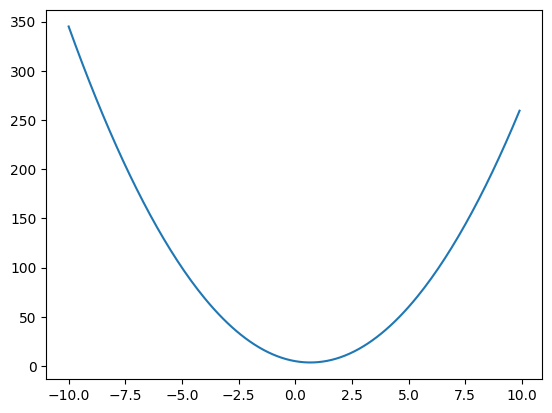

In [277]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [278]:
# derivative approximation
h = 0.0000001
x = 3.0
(f(x + h) - f(x)) / h

14.000000305713911

In [279]:
h = 0.0000001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c # how much will d change if a changes?
a += h
d_h = a*b + c
print(d, d_h, (d-d_h)/h)

4.0 3.9999997 2.9999999995311555


In [280]:
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.grad = 0.0
        self._label = label
    
    def __repr__(self):
        # tostring() in python
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        # backward propogates current gradient backwards to direct children
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __radd__(self,other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def exp(self): # e^x
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        # build topological order so that we can backprop all parents/further nodes before children
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [281]:
def trace(n):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(n)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label=f"{n._label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(uid + n._op, label=n._op)
            dot.edge( uid + n._op, uid)
    for n1, n2 in edges:
        uid1, uid2 = str(id(n1)), str(id(n2))
        dot.edge(uid1, uid2 + n2._op)
    return dot

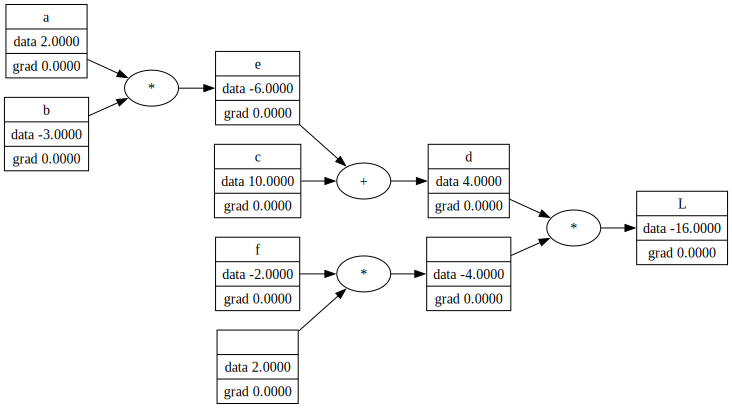

In [282]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e._label = 'e'
d = e + c; d._label = 'd'
f = Value(-2.0, label='f') * 2
L = d * f; L._label = 'L'
draw_dot(L)

In [283]:
# L = d * f
# so what is dL/dd?

# (f(x + h) - f(x)) / h, h -> 0
# ((d + h) * f - d * f) / h
# (d*f + f*h - d*f) / h
# f*h / h
# f

In [284]:
# calculating dL/dc

# local derivatives
# d = c + e, so
# dd/dc = 1.0
# dd/de = 1.0

# chain rule (think about it as rate of changes)

# dL/dc = dL/dd * dd/dc = -2.0 * 1.0 = -2.0


In [285]:
# Simulating a neuron using our Value class
# neuron has two inputs x1,x2
# o = tanh(x1w1 + x2w2 + b)

# input x1,x2
x1 = Value(2.0, label='x')
x2 = Value(0.0, label='y')

# weights w1,w2
w1 = Value(-3.0, label='w')
w2 = Value(1.0, label='w')

# bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'
# derivative of tanh
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

In [286]:
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

# draw_dot(o)

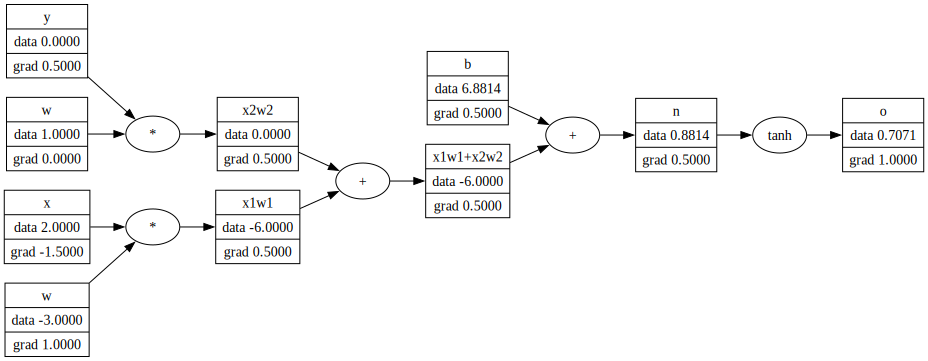

In [287]:
o.backward()

draw_dot(o)

In [358]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # sum default value
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts): # in layers, list of output sizes
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
print(n(x))
print(len(n.parameters()))

Value(data=0.8442605140284667)
41


In [289]:
# visualize entire network, very big
# draw_dot(n(x))

In [364]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

# intial predictions are random
n = MLP(3, [4,4,1])

In [367]:
for k in range(1001):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(pred - actual)**2 for pred, actual in zip(ypred, ys)])

    # since grads do +=, we need to reset each time
    # torch.zero_grad()
    for p in n.parameters():
        p.grad = 0.0
        
    # backward pass
    loss.backward()

    # a positive gradient means increasing value will increase the loss
    # neg is inverse
    for p in n.parameters():
        p.data += -0.05 * p.grad
    if k % 100 == 0:
        print(k, loss.data)

0 0.0037800353586148645
10 0.0034908306098949465
20 0.0032408190851328806
30 0.003025053951905124
40 0.002838032287296295
50 0.002668562280421796
60 0.0025219584501523654
70 0.0023911446411686143
80 0.002274100096253325
90 0.0021662360105638833
100 0.0020712363549063345
110 0.001983609902833421
120 0.0019021379916629587
130 0.001827746681448786
140 0.0017580814678877785
150 0.0016943559885354057
160 0.0016333498834009193
170 0.0015785809561659069
180 0.0015266301405146335
190 0.0014788509153537445
200 0.0014344989791107965
210 0.0013922964379143397
220 0.0013514034659410552
230 0.0013134589394926603
240 0.0012769766095998799
250 0.001243972681664597
260 0.0012113623017971894
270 0.001180357320835748
280 0.0011513577827869839
290 0.0011235776590546027
300 0.0010972362571194686
310 0.0010723455946962798
320 0.0010483286204620679
330 0.001025127520099152
340 0.0010034167735053449
350 0.0009823889250483169
360 0.0009625670459307472
370 0.0009434468593986617
380 0.0009249154715144098
390 0.

In [362]:
ypred

[Value(data=1.0),
 Value(data=-0.9999998466462336),
 Value(data=-0.9999998466376333),
 Value(data=1.0)]